<h2 align=center>Movie Review Classification with BERT & TensorFlow</h2>

In this [project](https://udemy.com/), you will learn how to fine-tune a BERT model for fake news classification using TensorFlow and TF-Hub.

## Task 1: Setup your TensorFlow and Colab Runtime.

### Check GPU Availability

Check if your Colab notebook is configured to use Graphical Processing Units (GPUs). If zero GPUs are available, check if the Colab notebook is configured to use GPUs (Menu > Runtime > Change Runtime Type).



In [22]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


### Install TensorFlow and TensorFlow Model Garden

In [24]:
!pip3 install tensorflow
import tensorflow as tf
print(tf.version.VERSION)

Defaulting to user installation because normal site-packages is not writeable


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
!pip install -q tensorflow==2.4.0

In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

## Restart the Runtime

**Note** 
After installing the required Python packages, you'll need to restart the Colab Runtime Engine (Menu > Runtime > Restart runtime...)



## Task 2: Download and Import the Quora Questions Dataset

In [ ]:
!pip install tensorflow
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

## Task 3: **Download** Fake news Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/gdrive/My Drive/data/moviereviews/IMDB Dataset.csv' './moviereviews.csv'


A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('review.csv',low_memory=False)
df.shape
df.tail(20)


,qid,question_text,target
1048555,cd753e03d4c6b1bb4588,Have you ever been in the middle of saying or ...,0
1048556,cd755074155b3dad1cca,Is it normal for ENFJs to push people away?,0
1048557,cd7551546427c94bee93,Why do Indian right wingers detest when Indian...,1
1048558,cd7563214f48efc94940,"Do Germans living in border areas speak Dutch,...",0
1048559,cd757b2a523db16fde56,How can I overcome a really bad fear?,0
1048560,cd757ed4c44d7d37f247,Has anyone bought a Chevrolet car after Chevro...,0
1048561,cd75804e6f7edab8d73f,What will happen to my phone if I use it only ...,0
1048562,cd75853e0694f6f5028e,What do you like best about the series The Goo...,0
1048563,cd75a04abbe775d06b47,"If you had to name your lifestyle, what would ...",0
1048564,cd75a9ce0e1990e3502f,Why are some countries in two continents at once?,0


In [10]:
#check few rows in true news Dataset
df.tail(20)
df['text'] = df['question_text']
df['target'] = np.where(df['target']=='positive', 1, 0)

In [9]:
#check few rows in fake news Dataset
df.tail(20)

,qid,question_text,target,text
1048555,cd753e03d4c6b1bb4588,Have you ever been in the middle of saying or ...,0,Have you ever been in the middle of saying or ...
1048556,cd755074155b3dad1cca,Is it normal for ENFJs to push people away?,0,Is it normal for ENFJs to push people away?
1048557,cd7551546427c94bee93,Why do Indian right wingers detest when Indian...,0,Why do Indian right wingers detest when Indian...
1048558,cd7563214f48efc94940,"Do Germans living in border areas speak Dutch,...",0,"Do Germans living in border areas speak Dutch,..."
1048559,cd757b2a523db16fde56,How can I overcome a really bad fear?,0,How can I overcome a really bad fear?
1048560,cd757ed4c44d7d37f247,Has anyone bought a Chevrolet car after Chevro...,0,Has anyone bought a Chevrolet car after Chevro...
1048561,cd75804e6f7edab8d73f,What will happen to my phone if I use it only ...,0,What will happen to my phone if I use it only ...
1048562,cd75853e0694f6f5028e,What do you like best about the series The Goo...,0,What do you like best about the series The Goo...
1048563,cd75a04abbe775d06b47,"If you had to name your lifestyle, what would ...",0,"If you had to name your lifestyle, what would ..."
1048564,cd75a9ce0e1990e3502f,Why are some countries in two continents at once?,0,Why are some countries in two continents at once?


(1048575, 4)

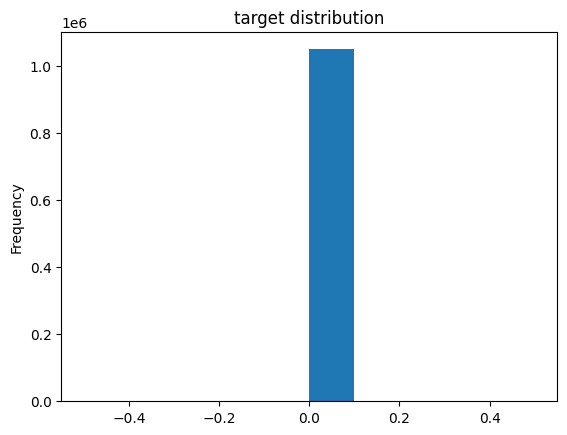

In [11]:
df.target.plot(kind='hist', title='target distribution')
df.shape

## Task 3: Create tf.data.Datasets for Training and Evaluation

In [12]:
train_df, remaining = train_test_split(df, random_state=42, train_size=0.9, stratify=df.target.values)
valid_df, remaining2 = train_test_split(remaining, random_state=42, train_size=0.5, stratify=remaining.target.values)
test_df, _  = train_test_split(remaining2, random_state=42, train_size=0.9, stratify=remaining2.target.values)


train_df.shape, valid_df.shape, test_df.shape

((943717, 4), (52429, 4), (47186, 4))

In [13]:
#with tf.device('/cpu:0'):
#!pip3 install tensorflow
!python -m pip install --user --upgrade pip
import tensorflow as tf
import tensorflow_hub as hub
train_data = tf.data.Dataset.from_tensor_slices((train_df['text'].values, train_df['target'].values))
valid_data = tf.data.Dataset.from_tensor_slices((valid_df['text'].values, valid_df['target'].values))
test_data =  tf.data.Dataset.from_tensor_slices((test_df['text'].values, test_df['target'].values)) 
for text, label in test_data.take(5):
 print(text)
 print(label)  

tf.Tensor(b'How do I calculate the concentration of each ion present in a solution formed by mixing 42.0mL of 0.170M NaOH and 37.6mL of 0.400M NaOH?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(b'Is ejaculate safe to drink?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(b'Why should I Join CETPA for Industrial Training in Noida?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(b'What is your opinion on the LODM Blog?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(b'What steps should I Take to heal after I quit smoking?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)


## Task 4: Download a Pre-trained BERT Model from TensorFlow Hub

In [26]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""
!pip3 install --upgrade transformers
!pip3 install torchvision
#from transformers import BertTokenizer, BertModel
from transformers.modeling_bert import BertModel, BertForMaskedLM
 # Label categories
 # 1 - Insincere Question
 # 0 - Sincere Question
label_list = [0,1]


 # maximum length of (token) input sequences
max_seq_length = 128
train_batch_size = 32

tokenizer=BertTokenizer.from_pretrained("bert_en_uncased_L-12_H-768_A-12_4")

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
#bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable=True)
#vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
#do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
#tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)





Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


OSError: Model name 'bert_en_uncased_L-12_H-768_A-12_4' was not found in tokenizers model name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased). We assumed 'bert_en_uncased_L-12_H-768_A-12_4' was a path or url to a directory containing vocabulary files named ['vocab.txt'] but couldn't find such vocabulary files at this path or url.

In [ ]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

In [ ]:
 tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

## Task 6: Tokenize and Preprocess Text for BERT

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray">Figure 2: BERT Tokenizer</p>
</div>

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [ ]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid=None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

  
  

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

## Task 7: Wrap a Python Function into a TensorFlow op for Eager Execution

In [ ]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text,label], Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])
  x = {'input_words_ids' : input_ids,
       'input_mask': input_mask,
       'input_type_id': segment_ids
       }  
  return (x, label_id)
  

## Task 8: Create a TensorFlow Input Pipeline with `tf.data`

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder=True)        
  .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder=True)        
  .prefetch(tf.data.experimental.AUTOTUNE))

  
  

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [ ]:
# train data spec
train_data.element_spec

In [ ]:
# valid data spec
valid_data.element_spec

## Task 9: Add a Classification Head to the BERT Layer

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

In [ ]:
# Building the model
def create_model():
  input_words_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_words_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
  input_type_id = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_id")
  pooled_output, sequence_output = bert_layer([input_words_ids, input_mask, input_type_id])
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(drop)
  model = tf.keras.Model(
           inputs = {
               'input_words_ids': input_words_ids,
               'input_mask': input_mask,
               'input_type_id': input_type_id          
           },
           outputs = output )
  return model

## Task 10: Fine-Tune BERT for Text Classification

In [ ]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

In [ ]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

In [ ]:
# Train model
epochs = 4
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)

## Task 11: Evaluate the BERT Text Classification Model

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
plot_graphs(history, 'binary_accuracy')

In [ ]:
sample_example = ["Every once in a while a movie comes, that truly makes an impact. Joaquins performance and scenography in all its brilliance. Grotesque, haunting and cringy. Hard to watch at times,... but so mesmerizing, you wont blink an eye watching it. Tragic, but with seriously funny moments. Emotional rollercoaster - sometimes, with multiple emotions popping-up at the same time.", 
                  "This is a very poor remake of Dirty Rotten Scoundrels and unlike that movie this one lacks in humor and talent, Rebel Wilson is woeful yet again, do not waste your money, go and rewatch the original",
                  "I went into this film expecting an all-time classic based on the reviews I had read & what I ended up watching was just a decent film overall. Phoenix is outstanding...so he definitely did his part",
                  'Apart from Eddie, the film is full of brilliant performances, in particularly by Wesley Snipes who matches and sometimes steals the show from Eddie',
                  'Do yourself a favor, watch the original and save your money. I am so tired of remaking the old movies and catering to women, and yes, I am a women']
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [1]*len(sample_example)))
test_data = test_data.map(to_feature_map).batch(1)
preds = model.predict(test_data)
threshold = 0.5
['positive' if pred >= threshold else 'negative' for pred in preds]

